In [0]:
import torch
import torchvision
import time
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import copy

In [0]:
#transforms.Normalize((x_mean,y_mean,z_mean),(x_sd,y_sd,z_sd))
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,))
                              ])

In [0]:
trainset = torchvision.datasets.FashionMNIST('./data', download=True, train=True, transform=transform)
valset = torchvision.datasets.FashionMNIST('./data', download=True, train=False, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=64,shuffle=True)

In [16]:
#sneak peak into the train data

#iterating into the data
dataiter = iter(trainloader)
images, labels = dataiter.next()

print(images.shape) #shape of all 4 images
print(images[1].shape) #shape of one image
print(labels[1].item()) #label number

torch.Size([64, 1, 28, 28])
torch.Size([1, 28, 28])
5


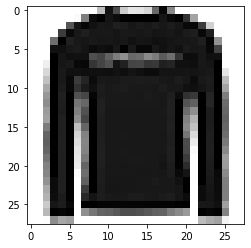

In [17]:
import matplotlib.pyplot as plt
plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')

In [0]:
class MnistFashionLeNet(nn.Module):
  def __init__(self):
    super(MnistFashionLeNet,self).__init__()
    self.feature=nn.Sequential(
        nn.Conv2d(1, 6, kernel_size = 5), #(N, 1, 28, 28) -> (N, 6, 24, 24)
        nn.Tanh(),
        nn.AvgPool2d(2, stride = 2), #(N, 6, 24, 24) -> (N, 6, 12, 12)
        nn.Conv2d(6, 16, kernel_size = 5), #(N, 6, 12, 12) -> (N, 16, 8, 8)
        nn.Tanh(),
        nn.AvgPool2d(2, stride = 2) #(N, 16, 8, 8) -> (N, 16, 4, 4)
    )
    self.classifer=nn.Sequential(
        nn.Linear(256, 120), # (N, 256) -> (N, 120)
        nn.Tanh(),
        nn.Linear(120, 84), # (N, 120) -> (N, 84)
        nn.Tanh(),
        nn.Linear(84, 10)  # (N, 84)  -> (N, 10)
    )
  def forward(self,x):
    x=self.feature(x)
    x=x.view(x.size(0),-1)
    return self.classifer(x)

In [0]:
device = torch.device("cuda")

In [0]:
def evaluation_gpu(dataloader):
  #function to calculate the accuracy
    total, correct = 0, 0
    for data in dataloader:
      inputs, labels = data
      inputs,labels= inputs.to(device),labels.to(device)
      outputs = model(inputs)
      #max_value, max_index = torch.max(tensor,axis)
      _, pred = torch.max(outputs.data, 1)
      #here total = total + batch_size
      total += labels.size(0)
      #here if pred and lables are equal then result will be 1 and we sum them up and fetch tensor value by item()
      correct += (pred == labels).sum().item()
      #print("Prediction from Model : ",pred)
      #print("labels : ",labels)
    return(100 * correct/total)

In [0]:
def fit_gpu(trainloader,valloader,model,opt,loss_fn,epochs=50):
        #callback=StopatLossValue()
        time0=time.time()
        trainloss=[]
        valloss=[]
        trainacclist=[]
        valacclist=[]
        min_valloss=10000000.0000000
        min_trainloss=10000000.0000000
        max_valacc=0.0
        max_trainacc=0.0
        for epoch in range(epochs):
            runningtrain_loss=0
            runningval_loss=0
            #init_fn()
            for i, data in enumerate(trainloader, 0):

                inputs, labels = data
                inputs=inputs.to(device)
                labels=labels.to(device)

                #forward pass
                loss = loss_fn(model(inputs), labels)

                #backward and optimize
                opt.zero_grad()
                loss.backward()
                opt.step()
                
                #loss_arr.append(loss.item())
                runningtrain_loss += loss.item()
            #init_fn()
            for i, data in enumerate(valloader,0):
                inputs, labels = data
                inputs=inputs.to(device)
                labels=labels.to(device)

                #forward pass
                loss = loss_fn(model(inputs), labels)
                #valloss_arr.append(loss.item())
                runningval_loss += loss.item()
            avgval_loss=runningval_loss/len(valloader)
            avgtrain_loss=runningtrain_loss/len(trainloader)
            if (avgval_loss<min_valloss):
                min_valloss=avgval_loss    
                vallossmodel=copy.deepcopy(model.state_dict())
            if (avgtrain_loss<min_trainloss):
                min_trainloss=avgtrain_loss
                trainlossmodel=copy.deepcopy(model.state_dict())
            trainacc=evaluation_gpu(trainloader)
            valacc=evaluation_gpu(valloader)
            trainacclist.append(trainacc)
            valacclist.append(valacc)
            if (trainacc>max_trainacc):
                max_trainacc=trainacc
                trainaccmodel=copy.deepcopy(model.state_dict())
            if (valacc>max_valacc):
                max_trainacc=valacc
                valaccmodel=copy.deepcopy(model.state_dict())      
            print("Minimum training Loss :",min_trainloss,"| Minimum validation Loss :",min_valloss) 
            print("Epoch {} - Training loss: {}".format(epoch,avgtrain_loss ),"| validation loss: {}".format(avgval_loss))    
            print('Epoch: %d/%d, Train acc: %0.2f' % (epoch, epochs-1,trainacc ),'| val acc: %0.2f' % (valacc))
            print('------------------------------------------------------------------------------------------')
            trainloss.append(avgtrain_loss)       
            valloss.append(avgval_loss)
            #vis.line(Y=avgtrain_loss, opts=dict(showlegend=True))
        print("Training Time(in minutes) =",(time.time()-time0)/60)    
        return vallossmodel,trainlossmodel,valaccmodel,trainaccmodel,trainloss,valloss,trainacclist,valacclist

In [22]:
#Train Model On GPU
model=MnistFashionLeNet()
#torch.load('/content/MNISTFashion9855.pt')
model = model.to(device)
opt=optim.Adam(model.parameters())
loss_fn=nn.CrossEntropyLoss()
vallossmodel,trainlossmodel,valaccmodel,trainaccmodel,trainloss,valloss,trainacclist,valacclist=fit_gpu(trainloader,valloader,model,opt,loss_fn)

Minimum training Loss : 0.6064311745070191 | Minimum validation Loss : 0.47155331834486336
Epoch 0 - Training loss: 0.6064311745070191 | validation loss: 0.47155331834486336
Epoch: 0/49, Train acc: 84.09 | val acc: 82.86
------------------------------------------------------------------------------------------
Minimum training Loss : 0.4111283472193075 | Minimum validation Loss : 0.4094229712607754
Epoch 1 - Training loss: 0.4111283472193075 | validation loss: 0.4094229712607754
Epoch: 1/49, Train acc: 86.35 | val acc: 84.88
------------------------------------------------------------------------------------------
Minimum training Loss : 0.3613021785516475 | Minimum validation Loss : 0.37798907251874353
Epoch 2 - Training loss: 0.3613021785516475 | validation loss: 0.37798907251874353
Epoch: 2/49, Train acc: 87.59 | val acc: 85.80
------------------------------------------------------------------------------------------
Minimum training Loss : 0.33506174180616954 | Minimum validation L

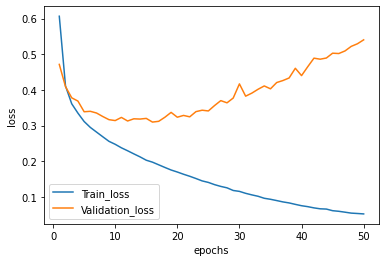

In [23]:
epochs=50
plt.plot([i for i in range(1,epochs+1)],trainloss,label="Train_loss")
plt.plot([i for i in range(1,epochs+1)],valloss,label="Validation_loss")
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

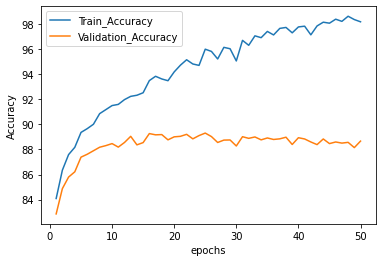

In [24]:
plt.plot([i for i in range(1,epochs+1)],trainacclist,label="Train_Accuracy")
plt.plot([i for i in range(1,epochs+1)],valacclist,label="Validation_Accuracy")
plt.xlabel('epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [25]:
#load dict of favourable model from trainaccmodel,valaccmodel,tainlossmodel,vallossmodel
model.load_state_dict(trainlossmodel)
torch.save(model,'fashionmnistLeNet.pt')

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type MnistFashionLeNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
